# Retail Store Management



We'll consider a retail store management.

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $R_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [2]:
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

## The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [3]:
# Utility functions for the Retail store environment

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m # Stock capacity
        self.h = h # Maintenance cost per unit
        self.c = c # Buying price per unit
        self.f = f # Selling price per unit
        self.d = d # Weekly average demand

    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        reward, self.state = self.sample(action)
        self.time += 1
        return reward

    def sample(self, action):
        """ Utility function to sample reward and next state. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state -self.c*action + self.f*min([demand, self.state+action, self.m])
        next_state = max([min([self.state+action, self.m])-demand, 0])
        return reward, next_state

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a + self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d)
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function()
        r_pi = np.sum(np.multiply(r, pi), axis=1)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function()
        p_pi = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi)
        p_pi = self.transition_policy(pi)
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi

## Experiments

### Simulation of Fixed Ordering Policies

We will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$ 


- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit
- Maximal Capacity: $m$
We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $R_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

0 :  -2.4  -> 9
1 :  2.6  -> 4
2 :  0.1  -> 5
3 :  0.0  -> 6
4 :  1.9  -> 5
5 :  3.0  -> 3
6 :  -1.8  -> 6
7 :  1.9  -> 5
8 :  6.0  -> 0
9 :  0.5  -> 1
10 :  0.4  -> 2
11 :  -0.7  -> 4
Discounted reward: 4.7


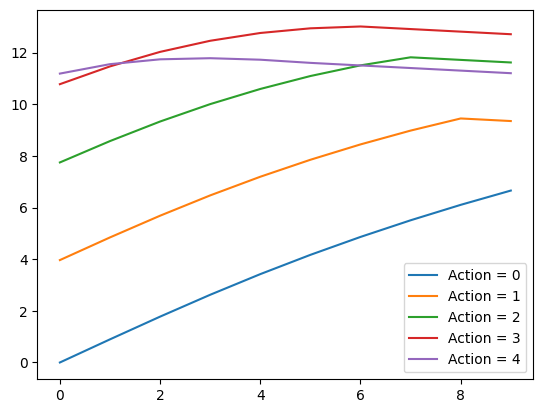

In [4]:
# Instantiate the retail store environment with the selected parameters
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

# Just an example of simulating a short trajectory and computing the cumulated reward
action = 3
env.reset(m)
n = 12
w = 1
v = 0
for _ in range(n):
    x = env.step(action)
    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

pi = np.zeros((m + 1, m + 1)) # Policy
pi[:, 0] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 0")
pi = np.zeros((m + 1, m + 1)) # Policy
pi[:, 1] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 1")
pi = np.zeros((m + 1, m + 1)) # Policy
pi[:, 2] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 2")
pi = np.zeros((m + 1, m + 1)) # Policy
pi[:, 3] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 3")
pi = np.zeros((m + 1, m + 1)) # Policy
pi[:, 4] = 1
plt.plot(env.value_policy(pi, gamma), label="Action = 4")


plt.legend()

Choice of parameters:

- Maximal Capacity: $m = 9$ A small maximal capacity main reduce the reward function in our case since we calculate self.f*min([demand, self.state+action, self.m])

- Maintenance Cost: $h = 0.1$ The bigger less bicycles we tend to have in our stock since it decreases the reward function if we have too many bicycles.
- Ordering Cost: $c = 0.5$ It influences the reward function in a similar way to the maintenance cost.
- Sales Profit: $f = 1$ The sales profit controls the influence (like the weight of a regularizatioon term) stochastic part of our reward function since the demand is sampled from a probabilist distribution (is stochastic).

- The parameter $d = 4$ also influences in the stochastic part, but it determines how scattered is the distribution from which we sample.

- The parameter $\gamma = 0.875$ is the discount factor of the reward function. It's used so the model prioritize immediate rewards mroe then the future ones, since they are more uncertain.


Taking the same action multiple times yields similar results (using the same action) if we run the simulation multiple times, it could perform better, since we can use our reward function to estimate our best action. As we can see in the plot our value function depends on the choice of the action to be taken. I think we can find better policies, for example one policy that orders less bikes if we have the stock almost full.

### Computing the Optimal Policy by Policy Iteration


In [10]:

# Initialize environment and parameters
m, h, c, f, d, gamma = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)
pi = np.random.randint(0, 1, size=(m + 1, m + 1))  # Arbitrary initial policy
v = env.value_policy(pi, gamma)

def greedy_policy(env, gamma, v):
  q = np.zeros((m+1, m+1))
  for s in range(m):
    for a in range(m):
      q[s, a] = env.reward_function()[s, a] + gamma * np.sum(env.transition_function()[s, a, :] * v)
  optimal_actions = np.argmax(q, axis=1)
  return q, optimal_actions
for i in range(5):
  v = env.value_policy(pi, gamma)
  q, optimal_actions = greedy_policy(env, gamma, v)
  for s, optimal_action in enumerate(optimal_actions):
    pi[s] = np.eye(m+1)[optimal_action]
  print(pi)
# Optimal policy has converged in 'pi'

[[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1


We know it converged because the policy stabilized and remained the same after some iterations. The optimal policy tell us which is the best action for a given state in a deterministic way.

### Q Learning

In [ ]:
pi = np.ones((m + 1, m + 1)) / (m + 1)
v = env.value_policy(pi, gamma)
#Q, _ = greedy_policy(env, gamma, v)
Q = np.random.rand(m+1, m+1)

In [8]:
n = 10000
env.reset(m)
Q = np.zeros((m+1, m+1))
beta = 0.7
number_of_visits = np.zeros((m+1, m+1))

for i in range(n):
    action = np.random.choice(len(pi[env.state]), p=pi[env.state])
    number_of_visits[env.state, action] += 1
    reward, next_state = env.sample(action)
    max_next_action = np.argmax(Q[next_state, :])
    td_target = reward + gamma * Q[next_state, max_next_action]
    td_error = td_target - Q[env.state, action]
    alpha = number_of_visits[env.state, action]**-beta
    Q[env.state, action] += alpha * td_error
    env.step(action)

optimal_actions = np.argmax(Q, axis=1)
print(Q)
print(optimal_actions)

[[ 0.          0.          0.          0.          0.         12.40571078
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         12.74745806  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         13.24566599  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         13.60961267  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         13.96488174  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [14.36469881  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.   